## **Objective **
### Social Media Tweet Analysis on Twitter Dataset
*   Topic Modeling on Twitter Dataset
*   Sentiment analysis on Twitter Dataset








### **Business understanding**

### **Topic modeling**
Topic modeling is a type of statistical model for discovering the abstract "topics" that occur in a collection of texts.


*   Our task here is to discover abstract topics from tweets.


### **Sentiment analysis**
 It is used in social media monitoring, allowing businesses to gain insights about how customers feel about certain topics, and detect urgent issues in real time before they spiral out of control.


*   Our task here is to classify a tweet as a positive or negative tweet sentiment wise.




## Data Understanding
### Loading necessary packages

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import STOPWORDS,WordCloud
from gensim import corpora
import pandas as pd
import statistics
import string
import os
import re

Data acquisition

For this example we have two option for data acquisition:

*   You can download Twitter dataset directly from Twitter
*   By registering as a developer using this link [Here](https://developer.twitter.com/en) 

*   Or you can use downloaded data found at Week0/data/cleaned_fintech_data.csv 



In [ ]:
#To read csv file and create dataframe
tweets = pd.read_csv('../data/processed_tweet_data.csv')
tweets.head()

,created_at,source,original_text,polarity,subjectivity,lang,favorite_count,retweet_count,original_author,followers_count,friends_count,possibly_sensitive,hashtags,user_mentions,place
0,Fri Apr 22 22:20:18 +0000 2022,"<a href=""http://twitter.com/download/android"" ...",RT @nikitheblogger: Irre: Annalena Baerbock sa...,0.0,0.0,de,0.0,355.0,McMc74078966,3.0,12.0,NaN,NaN,nikitheblogger,NaN
1,Fri Apr 22 22:19:16 +0000 2022,"<a href=""http://twitter.com/download/android"" ...",RT @sagt_mit: Merkel schaffte es in 1 Jahr 1 M...,0.0,0.0,de,0.0,505.0,McMc74078966,3.0,12.0,NaN,NaN,sagt_mit,NaN
2,Fri Apr 22 22:17:28 +0000 2022,"<a href=""http://twitter.com/download/android"" ...",RT @Kryptonoun: @WRi007 Pharma in Lebensmittel...,0.0,0.0,de,0.0,4.0,McMc74078966,3.0,12.0,NaN,NaN,"Kryptonoun, WRi007",NaN
3,Fri Apr 22 22:17:20 +0000 2022,"<a href=""http://twitter.com/download/android"" ...",RT @WRi007: Die #Deutschen sind ein braves Vol...,0.0,0.0,de,0.0,332.0,McMc74078966,3.0,12.0,NaN,"Deutschen, Spritpreisen, inflation, Abgaben",WRi007,NaN
4,Fri Apr 22 22:13:15 +0000 2022,"<a href=""http://twitter.com/download/android"" ...",RT @RolandTichy: Baerbock verkündet mal so neb...,0.0,0.0,de,0.0,386.0,McMc74078966,3.0,12.0,NaN,NaN,RolandTichy,NaN


In [ ]:
def drop_unwanted_column(df: pd.DataFrame) -> pd.DataFrame:
    """
    remove rows that has column names. This error originated from
    the data collection stage.  
    """
    unwanted_rows = df[df['retweet_count'] == 'retweet_count'].index
    df.drop(unwanted_rows, inplace=True)
    df = df[df['polarity'] != 'polarity']

    return df

# def drop_duplicate(df: pd.DataFrame) -> pd.DataFrame:
#     """
#     drop duplicate rows
#     """

#     df = df.drop_duplicates().drop_duplicates(subset='original_text')

#     return df

def convert_to_datetime(df: pd.DataFrame) -> pd.DataFrame:
    """
    convert column to datetime
    """
    df['created_at'] = pd.to_datetime(df['created_at'], errors='coerce')

    df = df[df['created_at'] >= '2020-12-31']

    return df

def convert_to_numbers(df: pd.DataFrame) -> pd.DataFrame:
    """
    convert columns like polarity, subjectivity, retweet_count
    favorite_count etc to numbers
    """
    df['polarity'] = pd.to_numeric(df['polarity'], errors='coerce')
    df['subjectivity'] = pd.to_numeric(df['subjectivity'], errors='coerce')
    df['retweet_count'] = pd.to_numeric(df['retweet_count'], errors='coerce')
    df['favorite_count'] = pd.to_numeric(df['favorite_count'], errors='coerce')

    return df

def remove_non_english_tweets(df: pd.DataFrame) -> pd.DataFrame:
    """
    remove non english tweets from lang
    """

    df = df.query("lang == 'en'")

    return df

In [ ]:
#To get information abou the data
tweets.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9750 entries, 0 to 9749
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   created_at          9750 non-null   object 
 1   source              9749 non-null   object 
 2   original_text       9749 non-null   object 
 3   polarity            9749 non-null   float64
 4   subjectivity        9749 non-null   float64
 5   lang                9749 non-null   object 
 6   favorite_count      9749 non-null   float64
 7   retweet_count       9749 non-null   float64
 8   original_author     9749 non-null   object 
 9   followers_count     9749 non-null   float64
 10  friends_count       9749 non-null   float64
 11  possibly_sensitive  3758 non-null   object 
 12  hashtags            2959 non-null   object 
 13  user_mentions       7356 non-null   object 
 14  place               5850 non-null   object 
dtypes: float64(6), object(9)
memory usage: 1.1+ MB


In [ ]:
tweets['original_text'] =  tweets['original_text'].apply(lambda x: re.split('https:\/\/.*', str(x))[0])

In [ ]:
tweets.head()

,created_at,source,original_text,polarity,subjectivity,lang,favorite_count,retweet_count,original_author,followers_count,friends_count,possibly_sensitive,hashtags,user_mentions,place
0,Fri Apr 22 22:20:18 +0000 2022,"<a href=""http://twitter.com/download/android"" ...",RT @nikitheblogger: Irre: Annalena Baerbock sa...,0.0,0.0,de,0.0,355.0,McMc74078966,3.0,12.0,NaN,NaN,nikitheblogger,NaN
1,Fri Apr 22 22:19:16 +0000 2022,"<a href=""http://twitter.com/download/android"" ...",RT @sagt_mit: Merkel schaffte es in 1 Jahr 1 M...,0.0,0.0,de,0.0,505.0,McMc74078966,3.0,12.0,NaN,NaN,sagt_mit,NaN
2,Fri Apr 22 22:17:28 +0000 2022,"<a href=""http://twitter.com/download/android"" ...",RT @Kryptonoun: @WRi007 Pharma in Lebensmittel...,0.0,0.0,de,0.0,4.0,McMc74078966,3.0,12.0,NaN,NaN,"Kryptonoun, WRi007",NaN
3,Fri Apr 22 22:17:20 +0000 2022,"<a href=""http://twitter.com/download/android"" ...",RT @WRi007: Die #Deutschen sind ein braves Vol...,0.0,0.0,de,0.0,332.0,McMc74078966,3.0,12.0,NaN,"Deutschen, Spritpreisen, inflation, Abgaben",WRi007,NaN
4,Fri Apr 22 22:13:15 +0000 2022,"<a href=""http://twitter.com/download/android"" ...",RT @RolandTichy: Baerbock verkündet mal so neb...,0.0,0.0,de,0.0,386.0,McMc74078966,3.0,12.0,NaN,NaN,RolandTichy,NaN


In [ ]:
tweets['original_text'] = tweets['original_text'].str.replace('RT', '')
tweets['original_text'] = tweets['original_text'].str.split(':').str[1]

#### Check if there are errors in the data

In [ ]:
print("The number of missing value(s): {}".format(tweets.isnull().sum().sum()))
print("Columons having columns value:{}".format(tweets.columns[tweets.isnull().any()]))

The number of missing value(s): 23255
Columons having columns value:Index(['source', 'original_text', 'polarity', 'subjectivity', 'lang',
       'favorite_count', 'retweet_count', 'original_author', 'followers_count',
       'friends_count', 'possibly_sensitive', 'hashtags', 'user_mentions',
       'place'],
      dtype='object')


### Data Preparation 

*   Making correction 
*   Reformatting
*   Combining Dataset




In [ ]:
tweets_df = pd.DataFrame(columns=['text'])

tweets_df['text'] =  tweets['original_text'].to_list()
tweets_df['lang'] = tweets['lang']

In [ ]:
# drop row having Null value
tweets_df.dropna(inplace=True)


In [ ]:
tweets_df

,text,lang
0,Irre,de
1,"Merkel schaffte es in 1 Jahr 1 Million ""Flüch...",de
2,"@WRi007 Pharma in Lebensmitteln, Trinkwasser,...",de
3,Die #Deutschen sind ein braves Volk!. Mit #Sp...,de
4,Baerbock verkündet mal so nebenhin in Riga da...,de
...,...,...
9744,ఏప్రిల్ 24 సాయింత్రం 4 గంటలకు\n\nమెళియాపుట్టి...,te
9745,#Acharya movie BTS❤️.\n@KChiruTweets #SivaKor...,en
9746,*రాజమండ్రి రూరల్ నియోజకవర్గంలో ముస్లిం మహిళలు...,te
9747,జనసేన పార్టీ PAC సభ్యులు శ్రీ నాగబాబు గారిని ...,te


## **Assignment 1 for Practice**
### Write a function that change **Null** values for columns Hashtages by mostly occured Hashtage.



In [ ]:
def fill(df, text):
  df[tewxt] = df[text].fillna(df[text].mode()[0])


SyntaxError: ignored

In [ ]:
fill(tweets, 'hashtags')

In [ ]:
# tweets = drop_unwanted_column(tweets)
# #drop_duplicate(tweets)
# tweets = convert_to_numbers(tweets)
# tweets = convert_to_datetime(tweets)
# tweets = remove_non_english_tweets(tweets)

### uni-variate Analysis on Hashtags

In [ ]:
re.findall?

In [ ]:
#Method to find hashtags from tweets
def find_hashtags(tweet):
    '''This function will extract hashtags'''
    return re.findall('(#[A-Za-z]+[A-Za-z0-9-_]+)', tweet)

In [ ]:
tweets_df['text']

0                                                    Irre
1        Merkel schaffte es in 1 Jahr 1 Million "Flüch...
2        @WRi007 Pharma in Lebensmitteln, Trinkwasser,...
3        Die #Deutschen sind ein braves Volk!. Mit #Sp...
4        Baerbock verkündet mal so nebenhin in Riga da...
                              ...                        
9744     ఏప్రిల్ 24 సాయింత్రం 4 గంటలకు\n\nమెళియాపుట్టి...
9745     #Acharya movie BTS❤️.\n@KChiruTweets #SivaKor...
9746     *రాజమండ్రి రూరల్ నియోజకవర్గంలో ముస్లిం మహిళలు...
9747     జనసేన పార్టీ PAC సభ్యులు శ్రీ నాగబాబు గారిని ...
9748     శ్రీ @PawanKalyan గారి పర్యటనకు ఆటంకాలు కలిగి...
Name: text, Length: 5581, dtype: object

In [ ]:
# update Hashtage columon with hashtages extracted from Orignal_text columon
tweets_df['hashtags'] = tweets_df.text.apply(find_hashtags)
print(tweets_df['hashtags'])

0                                                      []
1                                                      []
2                                                      []
3       [#Deutschen, #Spritpreisen, #inflation, #Abgaben]
4                                                      []
                              ...                        
9744                                                   []
9745                            [#Acharya, #SivaKoratala]
9746                                                   []
9747                                                   []
9748                                                   []
Name: hashtags, Length: 5581, dtype: object


In [ ]:
# take the rows from the hashtag columns where there are actually hashtags
hashtags_list_df = tweets_df.loc[
                       tweets_df.hashtags.apply(
                           lambda hashtags_list: hashtags_list !=[]
                       ),['hashtags']]

In [ ]:
hashtags_list_df

,hashtags
3,"[#Deutschen, #Spritpreisen, #inflation, #Abgaben]"
6,[#Baerbock]
11,[#IchHabeNICHTMitgemacht]
12,[#Assange]
15,"[#Assange, #Held]"
...,...
9673,"[#Friday, #FridaysForFuture, #PeopleNotProfit,..."
9676,[#plastic]
9681,"[#ClimateActionNow, #IPCCReport, #ClimateEmerg..."
9689,[#Climatechange]


In [ ]:
 #create dataframe where each use of hashtag gets its own row
flattened_hashtags_df = pd.DataFrame(
    [hashtag for hashtags_list in hashtags_list_df.hashtags
    for hashtag in hashtags_list],
    columns=['hashtag'])

In [ ]:
flattened_hashtags_df

,hashtag
0,#Deutschen
1,#Spritpreisen
2,#inflation
3,#Abgaben
4,#Baerbock
...,...
2796,#Wildfires
2797,#burning
2798,#Climatechange
2799,#Acharya


In [ ]:
#add flatten_hashtags to tweet_df
tweets_df["flattened_hashtags"]= flattened_hashtags_df

In [ ]:
tweets_df

,text,lang,hashtags,flattened_hashtags
0,Irre,de,[],#Deutschen
1,"Merkel schaffte es in 1 Jahr 1 Million ""Flüch...",de,[],#Spritpreisen
2,"@WRi007 Pharma in Lebensmitteln, Trinkwasser,...",de,[],#inflation
3,Die #Deutschen sind ein braves Volk!. Mit #Sp...,de,"[#Deutschen, #Spritpreisen, #inflation, #Abgaben]",#Abgaben
4,Baerbock verkündet mal so nebenhin in Riga da...,de,[],#Baerbock
...,...,...,...,...
9744,ఏప్రిల్ 24 సాయింత్రం 4 గంటలకు\n\nమెళియాపుట్టి...,te,[],NaN
9745,#Acharya movie BTS❤️.\n@KChiruTweets #SivaKor...,en,"[#Acharya, #SivaKoratala]",NaN
9746,*రాజమండ్రి రూరల్ నియోజకవర్గంలో ముస్లిం మహిళలు...,te,[],NaN
9747,జనసేన పార్టీ PAC సభ్యులు శ్రీ నాగబాబు గారిని ...,te,[],NaN


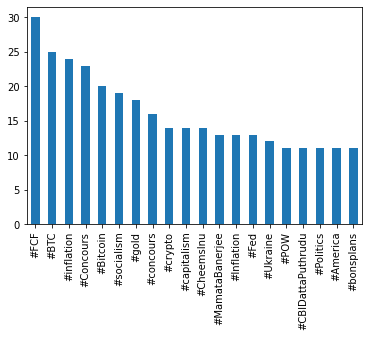

In [ ]:
# To plot Top 20 Hashtags
tweets_df['flattened_hashtags'].value_counts()[:20].plot(kind='bar')


### Analyzing data using language attribute

In [ ]:
#ploting Tweets by language 
tweet = pd.DataFrame(columns=['text','lang'])

tweet['text'] =  tweets_df['text'].to_list()
tweet['lang'] = tweets_df['lang'].to_list()

tweets_by_lang = tweet['lang'].value_counts()

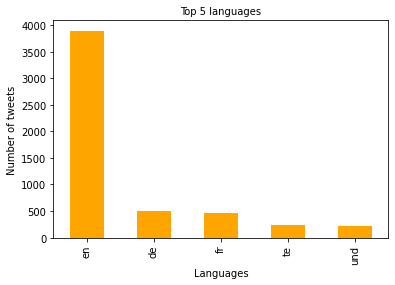

In [ ]:
fig, ax = plt.subplots()
ax.tick_params(axis='x', labelsize=10)
ax.tick_params(axis='y', labelsize=10)
ax.set_xlabel('Languages', fontsize=10)
ax.set_ylabel('Number of tweets' , fontsize=10)
ax.set_title('Top 5 languages', fontsize=10)
tweets_by_lang[:5].plot(ax=ax, kind='bar', color='orange')

In [ ]:
#from Our Language analysis we can see there are differnt languages we can select only tweets with english 
English_tweets = tweets_df.loc[tweets_df['lang'] =="en"]

In [ ]:
English_tweets

,text,lang,hashtags,flattened_hashtags
38,The 10-year yield is telling us that there's ...,en,"[#gold, #silver, #crypto]",#financial
39,"German 10y mortgage rate went from 0,8% to 2,...",en,[],#interventions
41,When?,en,[],#Anatomy
42,The 30-year mortgage rate in the US rises to ...,en,[],#BearMarket
43,Rates rise until something breaks … is anythi...,en,[],#yogiberra
...,...,...,...,...
9723,…,en,[],NaN
9726,\n☑️Follow…,en,[],NaN
9737,,en,[],NaN
9740,,en,[],NaN


###Text Preprocessing

In [ ]:
#text Preprocessing



In [ ]:
English_tweetsEnglish_tweets['clean_text']=English_tweets['text'].astype(str)
English_tweets['clean_text'] = English_tweets['text'].apply(lambda x: x.lower())
English_tweets['clean_text']= English_tweets['text'].apply(lambda x: x.translate(str.maketrans(' ', ' ', string.punctuation))).to_csv('../data/new_clean_data.csv', index=False)

In [ ]:
tweet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5581 entries, 0 to 5580
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    5581 non-null   object
 1   lang    5581 non-null   object
dtypes: object(2)
memory usage: 87.3+ KB


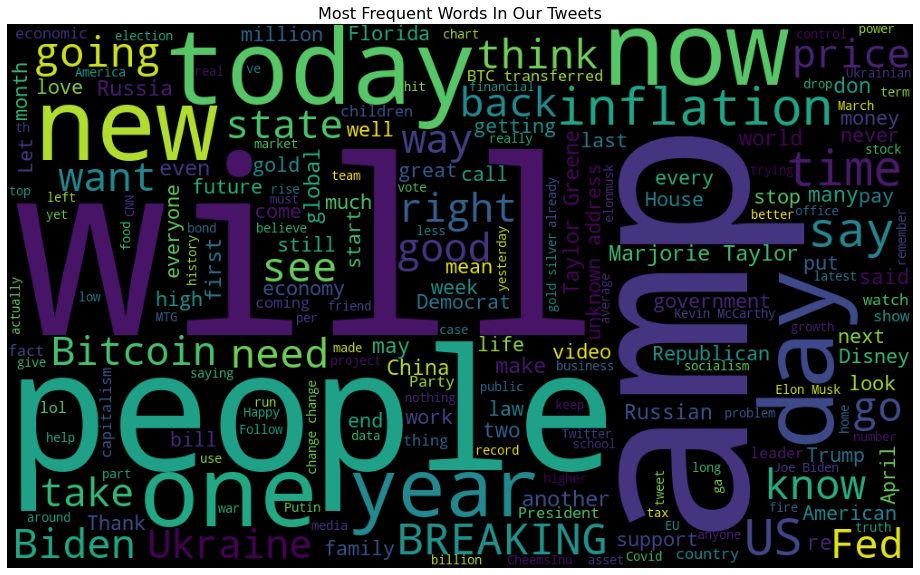

In [ ]:
plt.figure(figsize=(20, 10))
plt.imshow(WordCloud(width=1000,height=600,stopwords=STOPWORDS).generate(' '.join(English_tweets.text .values)))
plt.axis('off')
plt.title('Most Frequent Words In Our Tweets',fontsize=16)
plt.show()

## **Assignment 2 for Practice** 
Add additional Exploratory analysis function to 

*   Find top 10 mentioned names.



Here we cannot work with text directly when using machine learning algorithms.

Instead, we need to convert the text to numbers.
A simple and effective model for thinking about text documents in machine learning is called the Bag-of-Words Model, or BoW.

The model is simple in that it throws away all of the order information in the words and focuses on the occurrence of words in a tweets/document.

This can be done by assigning each word a unique number. Then any tweet we see can be encoded as a fixed-length vector with the length of the vocabulary of known words. The value in each position in the vector could be filled with a count or frequency of each word in the encoded document.

In [ ]:
#Converting tweets to list of words For feature engineering
sentence_list = [tweet for tweet in English_tweets['text']]
word_list = [sent.split() for sent in sentence_list]

word_list[:2]


[['The',
  '10-year',
  'yield',
  'is',
  'telling',
  'us',
  'that',
  "there's",
  'a',
  'high',
  'risk',
  'of',
  'something',
  "'breaking'",
  'in',
  'the',
  'system',
  '#gold',
  '#silver',
  '#crypto',
  '#…'],
 ['German',
  '10y',
  'mortgage',
  'rate',
  'went',
  'from',
  '0,8%',
  'to',
  '2,50%',
  '👇',
  'Can',
  'you',
  'hear',
  'the',
  'sound',
  'of',
  'German',
  'real',
  'estate',
  'bubble',
  'bursting?',
  'https']]

In [ ]:
#Create dictionary which contains Id and word 
word_to_id = corpora.Dictionary(word_list)
for k, v in word_to_id.items():
    print(k,"........",v)

Streaming output truncated to the last 5000 lines.
11932 ........ Ullmark
11933 ........ healthier.G
11934 ........ Cassidy
11935 ........ Hampus
11936 ........ Lindholm
11937 ........ Pastrnak
11938 ........ Sunday/Tuesday.@wbznew…
11939 ........ expects
11940 ........ update.Bruce
11941 ........ @pax
11942 ........ Boston.
11943 ........ PAX
11944 ........ Returns
11945 ........ depends
11946 ........ disas…
11947 ........ inferior
11948 ........ other.
11949 ........ other—and
11950 ........ superior
11951 ........ what.
11952 ........ dumping
11953 ........ immigrants
11954 ........ @pulte
11955 ........ Dad,
11956 ........ Ok
11957 ........ U
11958 ........ infected
11959 ........ let's
11960 ........ minute
11961 ........ molar
11962 ........ stomach
11963 ........ Jesus
11964 ........ Revelator,
11965 ........ Lord
11966 ........ gratitude
11967 ........ what!
11968 ........ Always.
11969 ........ Help.
11970 ........ People.
11971 ........ Guard.
11972 ........ prayers
11973 ..

In [ ]:
corpus = [word_to_id.doc2bow(tweet) for tweet in word_list]

In [ ]:
corpus[:2]

[[(0, 1),
  (1, 1),
  (2, 1),
  (3, 1),
  (4, 1),
  (5, 1),
  (6, 1),
  (7, 1),
  (8, 1),
  (9, 1),
  (10, 1),
  (11, 1),
  (12, 1),
  (13, 1),
  (14, 1),
  (15, 1),
  (16, 1),
  (17, 1),
  (18, 1),
  (19, 1),
  (20, 1)],
 [(11, 1),
  (17, 1),
  (21, 1),
  (22, 1),
  (23, 1),
  (24, 1),
  (25, 2),
  (26, 1),
  (27, 1),
  (28, 1),
  (29, 1),
  (30, 1),
  (31, 1),
  (32, 1),
  (33, 1),
  (34, 1),
  (35, 1),
  (36, 1),
  (37, 1),
  (38, 1),
  (39, 1)]]

### Modeling